## Integrate L-Py with xarray-simlab

https://xarray-simlab.readthedocs.io

### Write Lpy file and save it

In [73]:
from openalea.lpy.lsysparameters import LsystemParameters
from openalea.plantgl.all import *
from numpy import arange
from math import *

strides = 10
p1 = Polyline2D([(v,0) for v in arange(0,1.01,1/strides)])
p2 = Polyline2D([(2*sin(a)/pi,2*(cos(a))/pi) for a in arange(0,pi/2+0.01,pi/(2*strides))])
p3 = Polyline2D([(-0.5,0),(0,-0.1),(0.5,0)])
rd = Polyline2D([(0,0.1),(0.7,1),(1,0.01)])

lp = LsystemParameters()
lp.add(name='strides', value=strides)
lp.add_curve(name='path1', value=p1)
lp.add_curve(name='path2', value=p2)
lp.add_curve(name='section', value=p3)
lp.add_function(name = 'radius', value=rd)
lp.set_option('Turtle Path Optimization',0)


In [74]:
%%writefile .lpydevel.lpy

import matplotlib.pyplot as plt
import matplotlib as mpl

color = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=20), cmap=plt.cm.hsv)

#################################

from numpy import exp, linspace, nan, arange

#################################


def interpolate(c1, c2, t):
  return Polyline2D([Vector2(pi1)*(1-t)+Vector2(pi2)*t for pi1,pi2 in zip(c1,c2)])


#################################

tip = 5
b = 1.5
fsize = 10

growth_logistic = lambda ttime : fsize / (1. + exp(-(ttime-tip)/b ))

def growth_rate(ttime): 
    expt = exp(-(ttime-tip)/b)
    return fsize * expt / (b* (1. + expt)**2)

#################################

extern(flush_delay = None)
extern(nb_metamers = None)
extern(step_delta = None)

assert not path1 is None

#################################

module Metamer(t, size, parent, lighting, allocation)
module Apex(t, lastmetamer)

#################################

Axiom:  R Apex(0, nan)

derivation length: 1
production:

Apex(t, lm) :
    if (t % flush_delay) < step_delta and (t // flush_delay) < nb_metamers:
        p = MetamerParams(t=0, size=0.5, parent=lm)
        lm = p.uid        
        nproduce Metamer(p)
    produce Apex(t+step_delta, lm)

Metamer(p):
    p.t += step_delta
    p.size += p.allocation # growth_rate(p.t)*step_delta#
    #p.size = growth_logistic(p.t)
    produce Metamer(p)

decomposition:

interpretation:

R --> _(0.3)@Gc SetColor(Material('green',(1,15,1),diffuse=10,specular=(0,0,0)))

Metamer(p) :
    global path1
    assert not path1 is None
    l = p.size
    r, g, b, a = map(lambda v : int(v*255), color.to_rgba(p.lighting))
    nproduce F(l/3) /(137)[SetColor(r, g, b)_(0.1) @Gc Sweep(interpolate(path1, path2, max(1,p.t/5)), section, l,l/strides, l/4, radius)]

Apex(t,lm) --> F(1) @O


Overwriting .lpydevel.lpy


In [75]:
import xsimlab as xs
from lpy_simlab_process import xs_lpyprocess

xs_lpyprocess('LpyDevel', '.lpydevel.lpy', lp, modulestoconsider=['Metamer'], 
              propertymapping={
                              'Metamer_lighting' : xs.global_ref('Metamer_lighting', intent='in'),
                              'Metamer_allocation' : xs.global_ref('Metamer_allocation', intent='in')
                              }
             )



lpy_simlab_process.LpyDevel

In [76]:
import numpy as np

@xs.process
class Light():

   
    # process input
    Metamer = xs.foreign(LpyDevel, 'Metamer')
    lscene = xs.foreign(LpyDevel, 'lscene')
    lstring = xs.foreign(LpyDevel, 'lstring')
    
    #leaf_opt_properties = xs.variable()
   
    # process output
    Metamer_lighting = xs.variable(dims='Metamer', global_name='Metamer_lighting', intent='inout')
    
    def initialize(self):
        self.Metamer_lighting = np.zeros(len(self.Metamer))
    
    @xs.runtime()
    def run_step(self):
        from openalea.plantgl.light import directionalInterception, diffuseInterception
        res = diffuseInterception(self.lscene)
        #res = directionalInterception(self.lscene, [(0,0,1)], multithreaded=False, screenresolution=0.2)
        
        self.Metamer_lighting = np.zeros(len(self.Metamer))
        for k,v in res.items():
            if self.lstring[k].name == 'Metamer':
                self.Metamer_lighting[self.lstring[k][0].uid] = v
        # self.Metamer_lighting = np.array([res[i] for i in range(len(self.Metamer))])


In [77]:
from numpy import exp
tip = 5
b = 1.5
fsize = 10
def growth_rate(ttime): 
    expt = exp(-(ttime-tip)/b)
    return fsize * expt / (b* (1. + expt)**2)

In [78]:


@xs.process
class CarbonAllocation():

    conv_rate = 0.01

    # process input
    Metamer_t = xs.foreign(LpyDevel, 'Metamer_t')
    Metamer_parent = xs.foreign(LpyDevel, 'Metamer_parent')
    
    Metamer_lighting = xs.foreign(Light, 'Metamer_lighting')
    
    # process output
    Metamer_allocation = xs.variable(dims='Metamer', global_name='Metamer_allocation',  intent='inout')
    Metamer_demand = xs.variable(dims='Metamer', intent='out')

    total_demand = xs.variable(intent='out')
    total_supply = xs.variable(intent='out')
    
    reserves = xs.variable(intent='inout')
    
    def initialize(self):
        pass
    
    @xs.runtime(args=['step_delta'])
    def run_step(self, step_delta):
        #self.adjacency = np.zeros((nb_metamers,nb_metamers))
        #hasparent = isnan(self.Metamer_parent)== False
        #mparent = self.Metamer_parent[hasnoparent]
        #self.adjacency[(np.where(hasparent), mparent)] = 1
        
        #self.distances = csgraph.shortest_path(self.adjacency, directed=False).astype(np.float32)
        
        carbon = (self.Metamer_lighting * self.conv_rate) 
        self.Metamer_demand = growth_rate(np.array(self.Metamer_t))*step_delta
        
        autoallocated = np.minimum(carbon, self.Metamer_demand)
        
        demand = self.Metamer_demand - autoallocated
        supply = carbon - autoallocated
        
        self.total_demand = sum(demand)
        self.total_supply = sum(supply) + self.reserves
        
        if self.total_demand > 0:
            ratio = min(1,self.total_supply/self.total_demand)
            self.reserves = self.total_supply - self.total_demand*ratio
        
            self.Metamer_allocation = autoallocated+demand*ratio
        else:
            self.Metamer_allocation = autoallocated


### Create an xarray-simlab processes from an Lpy model

* __LpyDevel__, build lstring and scene and access computed variables 

### Create xarray-simlab model and simulation setup with the two processes

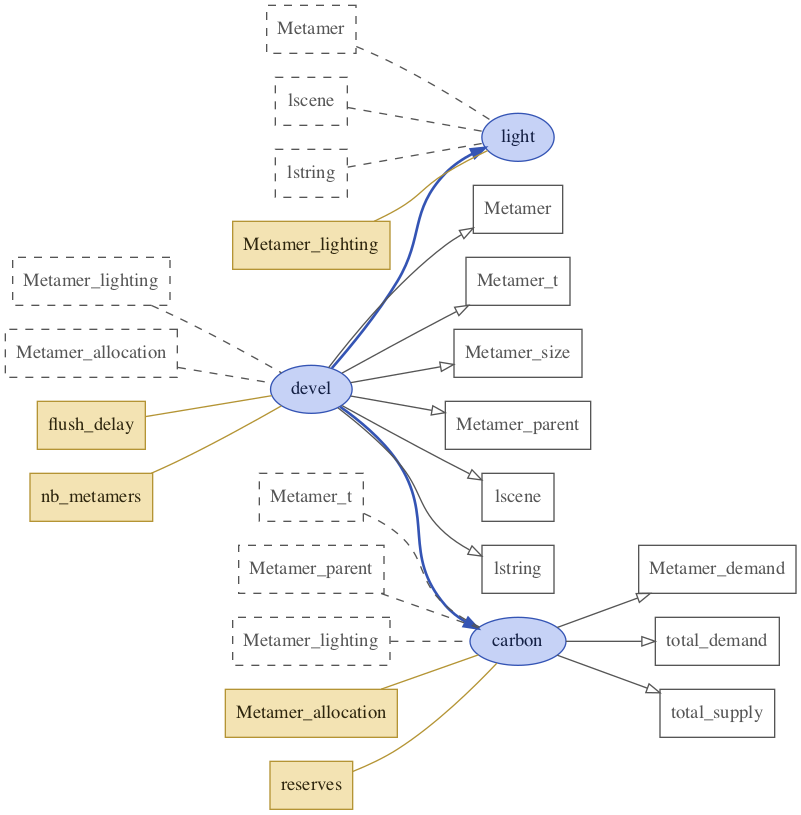

In [79]:
import numpy as np

model = xs.Model({ 'devel': LpyDevel  , 'light' : Light  , 'carbon' : CarbonAllocation  })
ds = xs.create_setup(
    model=model,
    clocks={ 'time': np.linspace(0, 25, 250) },
    input_vars={ 'devel': { 'flush_delay' : 2, 'nb_metamers' : 5 },
                 'light' : { 'Metamer_lighting' : np.array([], dtype=float)} ,
                 'carbon' : { 'Metamer_allocation' : np.array([], dtype=float) , 'reserves' : 10 } 
    },
    output_vars={
        'devel__Metamer_size': 'time',
        'light__Metamer_lighting': 'time',
        'carbon__Metamer_allocation': 'time',
        'carbon__Metamer_demand': 'time',
        'carbon__total_demand': 'time',
        'carbon__total_supply': 'time',
        'carbon__reserves': 'time',
    }
)
model.visualize(show_inputs=True, show_variables=True)

### Run the model and inspect results

In [80]:
from lpy_simlab_process import xs_lpydisplay_hook
ds_out = ds.xsimlab.run(model=model, hooks=xs_lpydisplay_hook('devel', scale = 1/50, delay = 0.01))
ds_out

SceneWidget(scenes=[{'id': 'HgKS3Vwyn40R5vZx7H5RiuxM3', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

<xarray.Dataset>
Dimensions:                     (Metamer: 5, time: 250)
Coordinates:
  * Metamer                     (Metamer) float64 0.0 1.0 2.0 3.0 4.0
  * time                        (time) float64 0.0 0.1004 0.2008 ... 24.9 25.0
Data variables:
    carbon__Metamer_allocation  (time, Metamer) float64 0.02226 ... 0.0002451
    carbon__Metamer_demand      (time, Metamer) float64 0.02226 ... 0.0002451
    carbon__reserves            (time) float64 9.984 9.967 9.948 ... 8.51 8.51
    carbon__total_demand        (time) float64 0.01607 0.0172 ... 0.0 0.0
    carbon__total_supply        (time) float64 10.0 9.984 9.967 ... 9.222 9.222
    devel__Metamer_size         (time, Metamer) float64 0.5 nan ... 7.967 9.348
    devel__flush_delay          int64 2
    devel__nb_metamers          int64 5
    light__Metamer_lighting     (time, Metamer) float64 0.6196 nan ... 15.71

### Plot output

In [81]:
import matplotlib.pyplot as plt

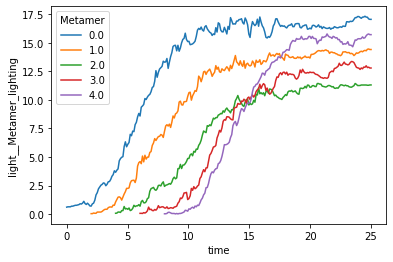

In [82]:
ds_out.light__Metamer_lighting.plot.line(x='time');

## Carbon allocation

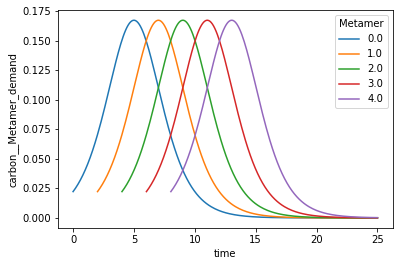

In [83]:
ds_out.carbon__Metamer_demand.plot.line(x='time');

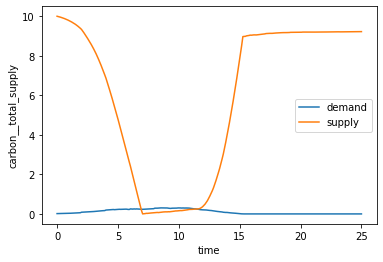

In [84]:
ds_out.carbon__total_demand.plot.line(x='time', label='demand', add_legend=False);
ds_out.carbon__total_supply.plot.line(x='time', label='supply', add_legend=False);
l = plt.legend()

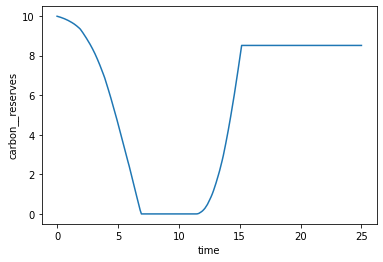

In [85]:
ds_out.carbon__reserves.plot.line(x='time');

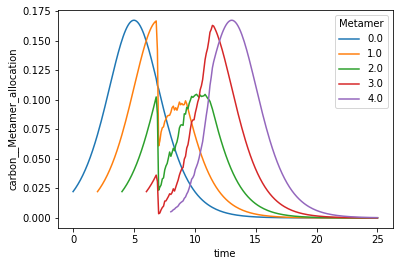

In [86]:
ds_out.carbon__Metamer_allocation.plot.line(x='time');